# Introduction

This repository provides guidance on utilizing R for the analysis of real estate data obtained through web scraping. The dataset comprises 5064 rows, encompassing real estate listings from numerous cities within the Metro Vancouver area as of July 20, 2021. However, due to limitations on the website, only up to 25 pages can be scraped for each city using the start URL, resulting in some lists being incomplete.

For insights into the scraping methodology employed, please refer to my other repository [RealEsatelist_scrape_clean_transform][1].
If you seek to scrape the complete list for each city in Vancouver, you may refer to [my article, which which utilizes a different website as an example][2]. However, note that this alternative source does not facilitate the extraction of land size data for houses. Nonetheless, it does allow for the extraction of list type information by adjusting the URL format and incorporating list type parameters.

                                                                                 
[1]:https://github.com/EvaWang2020/RealEsateDataAnalysis
[2]:https://evaanalytics.wixsite.com/website/post/use-scrapy-to-real-estate-data

### A peak of some of the insights uncovered: 

1) Land size has the greatest influence on list prices in Pitt Meadows, Bowen Island, and Vancouver.
2) Land size impacts least on list prices in Port Moody, Burnaby, and Richmond.
3) In Surrey and Langley, there appears to be a pattern where smaller apartments command higher average prices per square foot.
4) In Vancouver, there's a trend where larger apartments tend to have a higher average price per square foot.

### Import the dateset

In [ ]:
Data=read.csv("C://users/17789/Documents/Mentorship/RealEstateList/realestatelist_totallistappend.csv")   
Data$Price <- as.numeric(gsub('[$,]', '', Data$Price))

# Below is a glimpse of the data structure.
head(Data)

### Smmary the data of each numeric column. You can see the min, max, median, and quartiles

In [112]:
summary(Data[, c("Price", "Bedroom_qty", "Bathroom_qty", "Floor_size", "Land_width", "Land_depth" )])

     Price           Bedroom_qty      Bathroom_qty      Floor_size   
 Min.   :   84800   Min.   : 0.000   Min.   : 0.000   Min.   :    0  
 1st Qu.:  650000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.:  896  
 Median :  998000   Median : 3.000   Median : 2.000   Median : 1388  
 Mean   : 1431451   Mean   : 3.081   Mean   : 2.639   Mean   : 1910  
 3rd Qu.: 1650000   3rd Qu.: 4.000   3rd Qu.: 3.000   3rd Qu.: 2391  
 Max.   :46000000   Max.   :16.000   Max.   :12.000   Max.   :86250  
                                     NA's   :66       NA's   :61     
   Land_width        Land_depth    
 Min.   :   0.00   Min.   :   0.0  
 1st Qu.:  49.00   1st Qu.: 104.0  
 Median :  62.00   Median : 121.0  
 Mean   :  84.96   Mean   : 164.2  
 3rd Qu.:  75.00   3rd Qu.: 140.0  
 Max.   :3347.00   Max.   :9227.0  
 NA's   :3664      NA's   :3664    

### Check the list count of each city /city region

In [113]:
summary(Data[, c("City", "City_region")])

              City                  City_region  
 Vancouver      : 520   Coquitlam West    : 185  
 Surrey         : 511   Willoughby Heights: 174  
 Burnaby        : 501   Brighouse         : 125  
 North Vancouver: 498   Langley City      : 105  
 Richmond       : 498   Metrotown         : 100  
 Coquitlam      : 493   Downtown New West :  98  
 (Other)        :2042   (Other)           :4276  

### Calculate the average price per floor square foot by list type and city

In [114]:
# Calculate the average price per floor square foot (sf)
# Average price per square foot price = list price / floor size. floor size is not the same as land size
Average_sf_cost = Data$Price/Data$Floor_size 
# Caluclate land size
Landsize = (Data$Land_width)*(Data$Land_depth) 
# Add them as columns to the table Data
Data$Average_sf_cost <- Average_sf_cost 
Data$Landsize <- Landsize


# Ingnore the rows with missing or zero values in the column Floor_size
Subset_Data <- filter(Data, Data$Floor_size > 0 & !is.na(Data$Floor_size) )

# Calculate the average price per square foot. Any NA (missing) values should be removed before calculating the mean 
Subset_Avg_sf_price = mean(Subset_Data$Average_sf_cost, na.rm = TRUE)
round(Subset_Avg_sf_price)

[1] 785

In [115]:
# Calculate the average floor sf price by list type
# You can add more filters, such as setting up bedroom quantity 
# Subset_Data<- filter(Subset_Data, Subset_Data$Bedroom_qty==1)
# Subset_Data<- filter(Subset_Data, Subset_Data$Bathroom_qty==1)  
# Subset_Data<- filter(Subset_Data, Subset_Data$City=='Vancouver')  


# %>% is a pipe operator
ex1 <- Subset_Data %>% 
  group_by(List_type) %>% 
  summarize(Avg_price = round(mean(Average_sf_cost,na.rm = TRUE)), 
            Max_price = round(max(Average_sf_cost,na.rm = TRUE)),
            Min_price = round(min(Average_sf_cost,na.rm = TRUE)),
            List_count = length(Price))
ex1  %>%
    arrange(Avg_price)

List_type,Avg_price,Max_price,Min_price,List_count
Mfd/Mobile Home,316,1175,118,23
Recreational,526,526,526,1
Townhouse,619,1863,277,725
Multifamily,683,1605,322,34
Duplex,784,1544,351,80
House,815,22565,160,1970
Apt/Condo,817,3284,201,2164
Land/Lot,2386,5208,533,4


### Calculate the average price per square foot by city for apartments

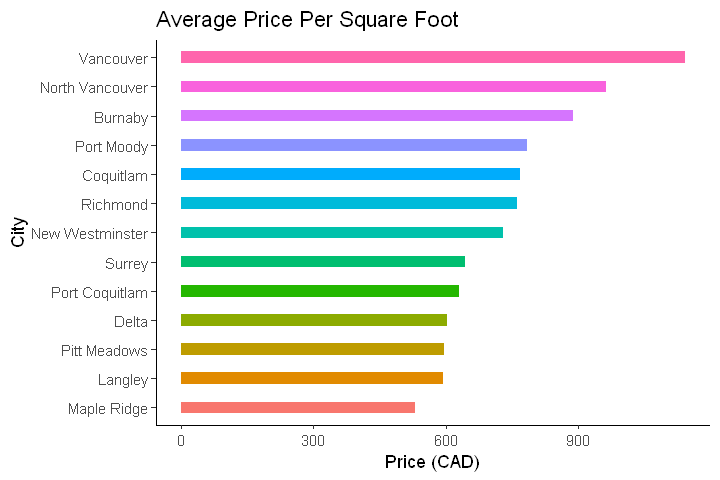

In [116]:
# Create a function to calculate the average price per square foot by city for apartment
# Install the ggplot2 library if you have not
# install.packages("ggplot2", repos = "https://cloud.r-project.org/")
library(ggplot2)

Subset_Data <- filter(Subset_Data, Subset_Data$List_type == 'Apt/Condo')
# You can add more filters, such as setting up bedroom quantity 
# Subset_Data <- filter(Subset_Data, Subset_Data$Bedroom_qty == 1)
# Subset_Data <- filter(Subset_Data, Subset_Data$Bathroom_qty == 1)  

ex1<-Subset_Data %>% 
    group_by(City) %>% 
    summarize(Avg_price = mean(Average_sf_cost, na.rm = TRUE), List_Count = length(Price) ) 

# Reorder City based on Avg_price from high to low
ex1$City <- factor(ex1$City, levels = ex1$City[order(ex1$Avg_price, decreasing = FALSE)])

options(repr.plot.width=6, repr.plot.height=4)
ggplot(ex1, aes(y = City, x = Avg_price, Color = City,fill=City)) +
    geom_bar(stat = "identity", width = 0.4, show.legend = FALSE) + 
    theme_classic() + 
    #scale_x_reordered() +
    labs(
        y = "City",
        x = "Price (CAD)",
        title = paste(
            "Average Price Per Square Foot"
     )
    )


### Calculate the frequency/list count for houses and apartments based on average square foot price

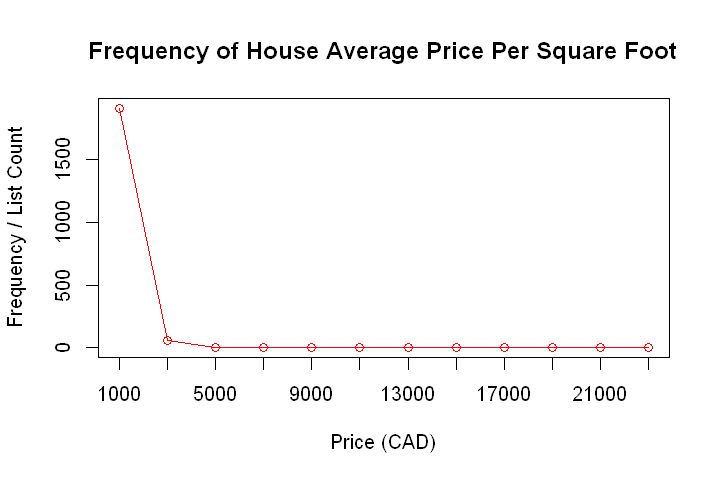

In [117]:
# Plot the frequency of each average price for house only
Subset_Data<- filter(Data, Data$Floor_size>0 & !is.na(Data$Floor_size) )
Subset_Data <- filter(Subset_Data, Subset_Data$List_type == 'House')

# You can add more filters, such as setting up specific city/cities
# Subset_Data <- filter(Subset_Data, Subset_Data$City == 'Vancouver')  

data = hist(Subset_Data$Average_sf_cost, plot = FALSE, breaks = 12)  
ymax = max(data[[2]])  # to find the maxium number of Y axis based on type 2 data of a vector
options(repr.plot.width = 6, repr.plot.height = 4)
plot(data[[4]],
     data[[2]], 
     type='o',
     ylab = "Frequency / List Count", 
     xlab = "Price (CAD)", 
     main = "Frequency of House Average Price Per Square Foot", 
     frame.plot = 'TRUE', 
     axes = FALSE, 
     ylim = c(0,ymax+1), 
     col = "red")  
# ylim is the function to limit the value of Y axis 

axis(1,data[[4]])
axis(2)


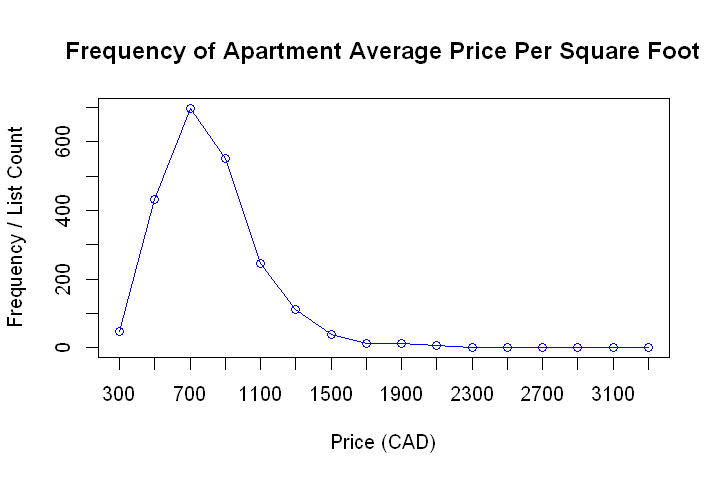

In [118]:
# Plot the frequency of each average price for apartment only
Subset_Data1 <- filter(Subset_Data1,  Subset_Data1$List_type == 'Apt/Condo')

# You can add more filters, such as setting up specific city/cities
# Subset_Data1 <- filter(Subset_Data1, Subset_Data1$City == 'Vancouver')  


data=hist(Subset_Data1$Average_sf_cost,plot=FALSE,breaks=12)  
ymax=max(data[[2]])  # to find the max number of Y axis based on type 2 data of a vector
options(repr.plot.width=6, repr.plot.height = 4)
plot(data[[4]],
     data[[2]], 
     type='o',
     ylab = "Frequency / List Count", 
     xlab="Price (CAD)", 
     main = "Frequency of Apartment Average Price Per Square Foot", 
     frame.plot = 'TRUE', 
     axes = FALSE, 
     ylim = c(0,ymax+1),col = "blue")  

axis(1,data[[4]])
axis(2)

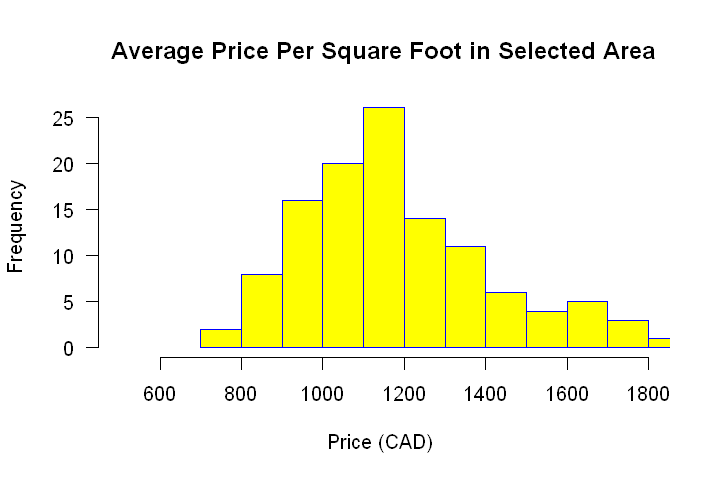

In [119]:
# Zoom in to check the frequency of average square foot price for specif areas
Subset_Data<- filter(Data, Data$Floor_size>0 & !is.na(Data$Floor_size) )
Subset_Data <- filter(Subset_Data,  Subset_Data$List_type == 'Apt/Condo')

Subset_Data <- filter(Subset_Data,  Subset_Data$City_region == 'Downtown West' |  Subset_Data$City_region == 'Coal Harbour' |  Subset_Data$City_region == 'Cambie' | Subset_Data$City_region == 'Yaletown')


hist(Subset_Data$Average_sf_cost,
     main = "Average Price Per Square Foot in Selected Area", 
     xlab = "Price (CAD) ", 
     border = "blue", 
     col = "yellow",
     xlim = c(500,1800),
     las = 1,
     breaks = 30 )


### Calculate the correlation between different variables of Metro Vancouver houses by city

In [120]:
# Some house listings lack land size values due to missing dimensions
# Consequently, after multiple layers of filtering, the total count of listings is smaller than the actual total count
Array = unique(Data$City, incomparables = FALSE)
n=length(Array)
for(i in 1:n ){
  A = Array[i]

  Subset_Data <- filter(Data, Data$Floor_size>0 & !is.na(Data$Floor_size) )
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Landsize))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bedroom_qty))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bathroom_qty))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Landsize))  
  Subset_Data <- filter(Subset_Data, Subset_Data$List_type == 'House')
  Subset_Data <- filter(Subset_Data, Subset_Data$City == A)
  
  x = Subset_Data$Average_sf_cost
  y = Subset_Data$Bedroom_qty
  z = Subset_Data$Bathroom_qty
  l = Subset_Data$Floor_size
  m = Subset_Data$Landsize
   
  X = cbind(x,y,z,l,m)  
  print(paste('Correlation Matrix of Housing Characteristics in', A))
  print(round(cor(X),5))
  print('--------------------------------------------------------')
}


[1] "Correlation Matrix of Housing Characteristics in Vancouver"
         x        y       z       l       m
x  1.00000 -0.20501 0.00929 0.12361 0.39713
y -0.20501  1.00000 0.68523 0.51877 0.12949
z  0.00929  0.68523 1.00000 0.73558 0.39265
l  0.12361  0.51877 0.73558 1.00000 0.67532
m  0.39713  0.12949 0.39265 0.67532 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing Characteristics in Langley"
         x        y        z        l        m
x  1.00000 -0.35265 -0.37316 -0.25582  0.53029
y -0.35265  1.00000  0.75735  0.55986  0.00751
z -0.37316  0.75735  1.00000  0.78102 -0.05277
l -0.25582  0.55986  0.78102  1.00000  0.15699
m  0.53029  0.00751 -0.05277  0.15699  1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing Characteristics in North Vancouver"
         x        y        z        l       m
x  1.00000 -0.27354 -0.31904 -0.44250 0.06243
y -0.27354  1.00000  0.68586  0.66453

### Utilize the correlation matrix of Richmond and Vancouver as examples to explain how to interpret the analysis

### Example 1

[1] "Correlation Matrix of Housing Characteristics in Richmond"
         x        y        z        l       m
x  1.00000 -0.19968 -0.16357 -0.07772 0.00092
y -0.19968  1.00000  0.59397  0.52311 0.02755
z -0.16357  0.59397  1.00000  0.71028 0.02315
l -0.07772  0.52311  0.71028  1.00000 0.28391
m  0.00092  0.02755  0.02315  0.28391 1.00000

- __x represents average price per square foot__
- __y represents average bedroom quantity__
- __z represents average bathroom quantity__ 
- __l represents average floor size__ 
- __m represents average land size__ 


>In examining the relationship between the average price per square foot (denoted as 'x') and the average land size (denoted as 'm') in Richmond, the correlation coefficient is calculated to be 0.00092. While this coefficient still denotes a positive correlation, its low magnitude suggests a notably weak relationship between the average price per square foot and land size.
>This weak correlation implies that  __<span style="color:red"> variations in land size have only a minimal impact on the average square foot price of houses in Richmond</span>.__  Other factors beyond land size likely play a more significant role in determining property prices in this area. Consequently, while land size may influence prices to some extent, its contribution appears to be negligible when compared to other influential factors within the Richmond housing market.



### Example 2

[1] "Correlation Matrix of Housing Characteristics in Vancouver"
         x        y       z       l       m
x  1.00000 -0.20501 0.00929 0.12361 0.39713
y -0.20501  1.00000 0.68523 0.51877 0.12949
z  0.00929  0.68523 1.00000 0.73558 0.39265
l  0.12361  0.51877 0.73558 1.00000 0.67532
m  0.39713  0.12949 0.39265 0.67532 1.00000

- __x represents average price per square foot__
- __y represents average bedroom quantity__
- __z represents average bathroom quantity__ 
- __l represents average floor size__ 
- __m represents average land size__ 




>Between the average price per square foot (denoted as 'x') and the average land size (denoted as 'm') in Vancouver, the correlation coefficient is 0.39713, which is much bigger when compared with that of Richmond. This suggests that __<span style="color:red"> larger land sizes are associated with higher average square foot prices of houses in Vancouver</span>__. This relationship likely stems from the fact that larger plots often accommodate more substantial or luxurious properties, which inherently command higher prices in the market.
>The significance of land size in determining property values in Vancouver cannot be overstated.

### Calculate the correlation between housing list price and land size

In [121]:
Array = unique(Data$City, incomparables = FALSE)
n=length(Array)
for(i in 1:n ){
  A = Array[i]

  Subset_Data <- filter(Data, Data$Floor_size>0 & !is.na(Data$Floor_size) )
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Landsize))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bedroom_qty))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bathroom_qty))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Landsize))  
  Subset_Data <- filter(Subset_Data, Subset_Data$List_type == 'House')
  Subset_Data <- filter(Subset_Data, Subset_Data$City == A)
  
  p = Subset_Data$Price
  m =Subset_Data$Landsize
   
  X = cbind(p,m)  
  print(paste('Correlation Matrix of Housing List Price and Land Size in', A))
  print(round(cor(X),5))
  print('--------------------------------------------------------')
}

[1] "Correlation Matrix of Housing List Price and Land Size in Vancouver"
        p       m
p 1.00000 0.81494
m 0.81494 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing List Price and Land Size in Langley"
        p       m
p 1.00000 0.76568
m 0.76568 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing List Price and Land Size in North Vancouver"
        p       m
p 1.00000 0.26371
m 0.26371 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing List Price and Land Size in Richmond"
       p      m
p 1.0000 0.2325
m 0.2325 1.0000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing List Price and Land Size in Maple Ridge"
      p     m
p 1.000 0.493
m 0.493 1.000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Housing List Price and Land Siz

#### Insights from the correlation output reveal that:

>__<span style="color:red">1) land size has the greatest influence on list prices in Pitt Meadows (coefficient: 0.93978), Bowen Island (coefficient: 0.82683), and Vancouver (coefficient: 0.81494)</span>__. 

>__<span style="color:red">2) The impact of land size on list prices is minimal in Port Moody (coefficient: 0.05306), Burnaby (coefficient: 0.19839), and Richmond (coefficient: 0.2325).</span>__


Empirical evidence and real estate analyses consistently highlight the pivotal role that land size plays in driving up average square foot prices in Vancouver. Therefore, it's evident that the __<span style="color:red">intrinsic value of land holds much greater weight in Vancouver's housing market compared to Richmond</span>__, profoundly influencing property prices.

### Calculate the correlation between different variables for Metro Vancouver apartments by city

In [123]:
Array=unique(Data$City, incomparables = FALSE)
n=length(Array)
for(i in 1:n ){
  A = Array[i]
  
  Subset_Data <- filter(Data, Data$Floor_size>0 & !is.na(Data$Floor_size) )
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bedroom_qty))
  Subset_Data <- filter(Subset_Data, !is.na(Subset_Data$Bathroom_qty))
  Subset_Data <- filter(Subset_Data, Subset_Data$List_type=='Apt/Condo')
  Subset_Data <- filter(Subset_Data, Subset_Data$City==A)
  
  x = Subset_Data$Average_sf_cost
  y = Subset_Data$Bedroom_qty
  z = Subset_Data$Bathroom_qty
  l = Subset_Data$Floor_size
   
  X=cbind(x,y,z,l)  
  print(paste('Correlation Matrix of Apartment Characteristics in', A))
  print(round(cor(X),5))
  print('--------------------------------------------------------')
}

[1] "Correlation Matrix of Apartment Characteristics in Vancouver"
        x       y       z       l
x 1.00000 0.30241 0.38590 0.40166
y 0.30241 1.00000 0.77728 0.68787
z 0.38590 0.77728 1.00000 0.79829
l 0.40166 0.68787 0.79829 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Apartment Characteristics in Langley"
         x        y        z        l
x  1.00000 -0.16166 -0.07615 -0.26667
y -0.16166  1.00000  0.58518  0.68132
z -0.07615  0.58518  1.00000  0.63153
l -0.26667  0.68132  0.63153  1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Apartment Characteristics in North Vancouver"
        x       y       z       l
x 1.00000 0.35419 0.44915 0.45605
y 0.35419 1.00000 0.79046 0.74226
z 0.44915 0.79046 1.00000 0.77357
l 0.45605 0.74226 0.77357 1.00000
[1] "--------------------------------------------------------"
[1] "Correlation Matrix of Apartment Characteristics in Richmond"
         x

### Pick Langley as an example to explain the above correlation output

[1] "Correlation Matrix of Apartment Characteristics in Langley"
         x        y        z        l
x  1.00000 -0.16166 -0.07615 -0.26667
y -0.16166  1.00000  0.58518  0.68132
z -0.07615  0.58518  1.00000  0.63153
l -0.26667  0.68132  0.63153  1.00000

- __x represents average price per square foot__
- __y represents average bedroom quantity__
- __z represents average bathroom quantity__ 
- __l represents average floor size__ 

>Between the average price per square foot (denoted as 'x') and the average floor size (denoted as 'l'), the correlation coefficient is -0.26667, indicating a negative correlation. This suggests that __<span style="color:red"> in Langley, there is a tendency for larger apartments to have lower prices per square foot </span>__.

>In simpler terms, as the average floor size increases in Langley, the price per square foot tends to decrease. This insight highlights an inverse relationship between apartment size and price per square foot in the Langley area

### Compare the average square foot prices of apartments between Vancouver and Surrey

[1] "Correlation Matrix of Apartment Characteristics in Vancouver"
        x       y       z       l
x 1.00000 0.30241 0.38590 0.40166
y 0.30241 1.00000 0.77728 0.68787
z 0.38590 0.77728 1.00000 0.79829
l 0.40166 0.68787 0.79829 1.00000

[1] "Correlation Matrix of Apartment Characteristics in Surrey"
         x        y       z        l
x  1.00000 -0.14714 0.05086 -0.15118
y -0.14714  1.00000 0.69331  0.64490
z  0.05086  0.69331 1.00000  0.73708
l -0.15118  0.64490 0.73708  1.00000


>For vancouver, between average price per square foot (denoted as 'x') and the average floor size (denoted as 'l'), the correlation coefficient is 0.40166, indicating a postive strong correlation. This suggests that __<span style="color:red">in Vancouver, there's a trend where larger apartments tend to have a higher average price per square foot</span>__. This contrasts with the situation in Langley, where the opposite holds true.

>For Surrey, between average price per square foot and the average floor size, the correlation coefficient is -0.15118. This means these two attributes are slightly negatively correlated. It seems that __<span style="color:red">in Surrey, there appears to be a pattern where smaller apartments command higher average prices per square foot. This mirrors the situation observed in Langley</span>__. 

### Data Quality Investigation: Why Bowen Island has so many "NA" (the missing value)?

[1] "Correlation Matrix of Apartment Characteristics in Bowen Island"
   x  y  z  l
x NA NA NA NA
y NA NA NA NA
z NA NA NA NA
l NA NA NA NA

> Because Bowen Island does not have apartment lists. It only has house lists

### Limitation of this analysis: 
- __<span style="color:red">Caution Regarding Averages</span>__: Averages can sometimes be misleading. For instance, in Vancouver's apartment market, there's a tendency for larger units to have a higher price per square foot on average. While this holds true for the overall average, a closer examination reveals that certain districts within Vancouver exhibit trends similar to Langley and Surrey, where smaller units command higher prices per square foot. For more insights on the risks of aggregation, refer to my article related to [risk of aggregation][2].
- Regarding the Dataset: The dataset currently includes data from a single day. However, you have the flexibility to add more data for your analysis. To learn how to append data from multiple days, you can refer to my repository [Scrape real estate data using spiders/crawlers and implement ETL.][1].This resource will guide you through the process of collecting and integrating data from various sources for a comprehensive analysis.
- Limitations of Web Scraping: It's important to note that the website I used for scraping limits the number of pages that can be scraped for each city to 25 using the start URL. As a result, some listings from the cities may be missing. If you wish to scrape the entire list for each city in Vancouver, you can refer to [my article, which provides an example using another website][3]. However, this alternative source may not allow scraping of land size for houses. Nonetheless, it does allow scraping of list types if you modify the URL format and include list type parameters.

[1]:https://github.com/EvaWang2020/RealEsateDataAnalysis
[2]:https://github.com/EvaWang2020/Analyze-real-estae-lists-using-R/blob/main/Risk%20of%20average%20and%20generalization.pdf
[3]:https://evaanalytics.wixsite.com/website/post/use-scrapy-to-real-estate-data